### Pipeline


#### Only Ubuntu/Linux/Debian


In [ ]:
import sys

sys.path.append("/usr/local/lib/python3.8/site-packages")
print(sys.path)

['C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\ADMIN\\AppData\\Local\\Programs\\Python\\Python310', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv', '', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\win32', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\win32\\lib', 'd:\\Documents\\Ki_8\\NLP\\Comment-Sentiment-Analysis\\myenv\\lib\\site-packages\\Pythonwin', '/usr/local/lib/python3.8/site-packages']


In [15]:
import pandas as pd
import string
import re
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from transformers import pipeline
import py_vncorenlp
import os

In [2]:
# Ghi nhớ thư mục gốc ngay từ đầu
PROJECT_ROOT = os.getcwd()
print("Thu mục gốc:", PROJECT_ROOT)

Thu mục gốc: d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\pre-processing


In [3]:
ABSOLUTE_MODEL_PATH = os.path.abspath("../attribute_extractor/vncorenlp")
print("Using model path:", ABSOLUTE_MODEL_PATH)

# Khởi tạo model từ thư mục local
vncorenlp_model = py_vncorenlp.VnCoreNLP(
    save_dir=ABSOLUTE_MODEL_PATH, max_heap_size="-Xmx2g"
)

Using model path: d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\attribute_extractor\vncorenlp


### Khởi tạo CorrectSpelling


In [4]:
os.path.join(PROJECT_ROOT, "vietnamese-correction-v2")

'd:\\School\\4thYear\\2ndSemester\\NLP\\Comment-Sentiment-Analysis\\pre-processing\\vietnamese-correction-v2'

In [ ]:
corrector = pipeline(
    "text2text-generation", model=os.path.join(PROJECT_ROOT, "vietnamese-correction-v2")
)

Device set to use cuda:0


### Làm sạch dữ liệu (xoá hàng comment trống hoặc nan)


In [18]:
df = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"))

In [19]:
df.shape

(2413, 4)

In [20]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file
534,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
535,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
536,iphone-15-plus,NaN,4,ratings\iphone-15-plus.csv
537,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
538,iphone-15-plus,NaN,1,ratings\iphone-15-plus.csv
...,...,...,...,...
2288,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2289,xiaomi-redmi-a3,NaN,4,ratings\xiaomi-redmi-a3.csv
2290,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2291,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv


In [21]:
# Xoá hàng chứa comment trống hoặc nan
df = df[df["comment"].str.len() > 1]

In [22]:
df.shape

(2313, 4)

In [23]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file


In [25]:
df.to_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"), index=False)

In [ ]:
before_total_words = df["comment"].apply(lambda x: len(x.split())).sum()
before_total_words

53287

### Pipeline xử lý cho văn bản tiếng Việt


In [ ]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open(
            os.path.join(PROJECT_ROOT, "../data/vietnamese.txt"), "r", encoding="utf-8"
        ) as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open(
            os.path.join(PROJECT_ROOT, "../data/vi-abbreviations.json"),
            "r",
            encoding="utf-8",
        ) as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        print("Before:", x)
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_abbreviations(x)
        x = self.correct_spelling(x)
        x = self.to_lower(x)

        print("After: ", x)
        return x


preprocessor = VietnamesePreprocessing()

#### Chia ra xử lý từng batch dữ liệu


In [ ]:
df_part1 = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part1.csv")
)
df_part2 = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part2.csv")
)
df_part3 = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part3.csv")
)
df_part4 = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part4.csv")
)
df_part5 = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part5.csv")
)

In [ ]:
for idx, row in df_part1.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part1.at[idx, "comment_clean_stage1"] = preprocessor(
        row["comment"]
    )  # Apply preprocessing

=====> Processing row 1
Before: Đừng mua, ko có linh kiện.
After:  đừng mua, không có linh kiện.
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo vui nó báo hiện tn cuộc gọi buồn thì nó im ru hên ít sài zalo chứ sài nhiều chắc vức
After:  máy sao cũng được ghét nhất cái zalo, vui nó báo hiện tên cuộc gọi, buồn thì nó im ru, hên ít sài zalo chứ sài nhiều chắc tức.
=====> Processing row 3
Before: Chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này mượt hơn nhiều 680 ở SS a05s vợ đag dùng
After:  chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này, mượt hơn nhiều 680 ở samsung a05s vợ đang dùng.
=====> Processing row 4
Before: sao hôm tôi mua lại ko dc tặng tai nghe như trong giới thiệu nhỉ hôm đấy tôi cũng có xem thấy khuyến mãi
After:  sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ, hôm đấy tôi cũng có xem thấy khuyến mãi.
=====> Processing row 5
Before: E Mua đc 1 tuần trả lại mất bao nhiêu % ạ
After:  e

In [ ]:
for idx, row in df_part2.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part2.at[idx, "comment_clean_stage1"] = preprocessor(
        row["comment"]
    )  # Apply preprocessing

=====> Processing row 1
Before: Sạc 25 lần tuột 1% pin kém quá
After:  sạc 25 lần tuột 1% pin kém quá!
=====> Processing row 2
Before: Màu xanh lá ,96% bán lại bao nhiêu ạ
After:  màu xanh lá , 96% bán lại bao nhiêu ạ?
=====> Processing row 3
Before: Sai mới 4thang mà hao hết 3% pin hối hận
After:  sai mới 4 tháng mà hao hết 3% pin, hối hận.
=====> Processing row 4
Before: Mới mua chưa đc 1tháng, dùng cũng mướt nhưng lâu lâu đag vào ứng dụng và treo và tự thoát ra, ko hỉu lý do
After:  mới mua chưa được 1 tháng, dùng cũng mướt nhưng lâu lâu đang vào ứng dụng và treo và tự thoát ra, không hiểu lý do.
=====> Processing row 5
Before: Mới sài có 8tháng pin còn 95%. Quá bưa.
After:  mới sài có 8 tháng pin còn 95%. quá bưa.
=====> Processing row 6
Before: Tôi mua được 4 tháng, giờ màn hình đổ mực. Khi nhân viên kiểm tra báo Tôi có cấn thân máy. Tôi không thấy. Nhưng tôi vẫn đồng ý,nhưng lại báo hãng có cấn màn hình và hãng báo không bảo hành. Tôi đã khiếu nại và đang chờ giải quyết. Không bi

In [ ]:
df_part2[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(
    os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part2.csv"),
    index=False,
)

In [ ]:
for idx, row in df_part3.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part3.at[idx, "comment_clean_stage1"] = preprocessor(
        row["comment"]
    )  # Apply preprocessing

=====> Processing row 1
Before: Ok
After:  ok!
=====> Processing row 2
Before: Nghe rõ chữ to
After:  nghe rõ chữ to.
=====> Processing row 3
Before: Sử dụng tốt, rất ok
After:  sử dụng tốt, rất ok.
=====> Processing row 4
Before: Bị lôi mới đổi lại cái moi
After:  bị lôi mới đổi lại cái mới.
=====> Processing row 5
Before: Rất tốt
After:  rất tốt.
=====> Processing row 6
Before: Tốt
After:  tốt.
=====> Processing row 7
Before: Ok
After:  ok!
=====> Processing row 8
Before: Chưa sạc lần nào cục sạc đã hư
After:  chưa sạc lần nào cục sạc đã hư.
=====> Processing row 9
Before: Mua lại máy đã qua sử dụng nói chung pin cũng ổn. Nhiều người đánh giá nói nhanh hết pin mặc dù không nghe gọi gì nhiều theo mình nghĩ chắc là tùy chiếc nhanh hết pin có chiếc không. Cũng tùy theo cách sạc điện thoại nữa. Đánh giá chung thì máy loa to nghe gọi rõ. Phím bấm nhẹ. Tuy nhiên máy chỉ có thể chụp ảnh và xem ảnh nghe nhạc chứ không xem được video và quay phim như thông số trên website của ĐMX đề cập. Một 

In [ ]:
df_part3[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(
    os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part3.csv"),
    index=False,
)

### Chạy lại pipeline (không có bước spell check)


In [5]:
df = pd.read_csv("../../data/processed_data/phone_ratings_full_parts.csv")
df = df[df["comment"].str.len() > 1]

In [ ]:
class VietnamesePreprocessingWithoutSpellCheck:
    def __init__(self):
        # Load Vietnamese stopwords
        pd_stopword = pd.read_csv("../../data/stopword/new_vietnamese_stopwords.csv")
        self.stop_words = set(
            pd_stopword[pd_stopword["is_stopword"] == 1]["word"].tolist()
        )
        with open("../../data/vi-abbreviations.json", "r", encoding="utf-8") as file:
            self.abbreviations = json.load(file)

            # Sort the abbreviations by length in descending order
            self.abbreviations = dict(
                sorted(
                    self.abbreviations.items(),
                    key=lambda item: len(item[0]),
                    reverse=True,
                )
            )
        self.vncorenlp_model = vncorenlp_model

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)  # replace multiple spaces with a single space

        # Replace '10d', '10đ', '10 điểm' to 'tốt' if > 8, 'khá' if > 5, 'tệ' if <= 5 (0-5)
        x = re.sub(
            r"\b(\d{1,2})(d|đ)\b",
            lambda match: (
                "tốt"
                if int(match.group(1)) > 8
                else "tạm" if int(match.group(1)) > 4 else "tệ"
            ),
            x,
        )

        # Loại bỏ ngày dd/mm/yyyy,...
        x = re.sub(r"\b\d{1,2}\s*[/-]\s*\d{1,2}(?:\s*[/-]\s*\d{2,4})?\b", "", x)
        x = re.sub(r"\b\d{1,2}\s*/\s*\d{4}\b", "", x)

        x = re.sub(r"\b0", "", x)  # remove digit 0 at the beginning

        # Remove phone number
        x = re.sub(
            r"(\d{10})", "", x
        )  # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(
            r"(xx\s*){2,}", "", x
        )  # remove phone number vietnam like xxx223654 hay 0905***654
        x = re.sub(r"(\*\s*)+", "", x)
        x = re.sub(r"\b\d+[xX\*]+\d+\b", "", x)  # Xoá các dãy số có chứa x hoặc *

        x = re.sub(
            r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b", "", x
        )  # remove email
        x = re.sub(
            r"\b\d+\b",
            lambda match: "" if int(match.group(0)) >= 100 else match.group(0),
            x,
        )  # remove number stand alone

        x = re.sub(
            r"\b\d+(?:\.\d+)?(tr\d+|tr|k)\b", "", x
        )  # Remove numbers >= 100 or numbers with 'tr' or 'k' (1tr5, 130k, 11940k)
        x = re.sub(
            r"\b\d+(?:\.\d+)?tr\d+(?:\.\d+)?k\b", "", x
        )  # Remove like that 11tr990k

        x = self.normalize_time_units(x)  # Normalize time units

        # Loại bỏ x% hay x %
        x = re.sub(r"\b\d+\s*%", "", x)
        x = re.sub(r"\s+", " ", x)  # replace multiple spaces with a single space
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def normalize_time_units(self, x: str) -> str:
        # Bước 1: Chuẩn hóa 30p, 2h, 10h30p → thêm khoảng trắng nếu cần
        x = re.sub(r"(\d+)([ph])\b", r"\1 \2", x)

        # Bước 2: Thay thế các đơn vị viết tắt thành đầy đủ
        x = re.sub(r"\b\d+\s*(p|phút)\b", "phút", x)
        x = re.sub(r"\b\d+\s*(h|giờ|tiếng)\b", "giờ", x)
        x = re.sub(r"\b\d+\s*(giây)\b", "giây", x)
        x = re.sub(r"\b\d+\s*(ngày)\b", "ngày", x)
        x = re.sub(r"\b\d+\s*(tháng)\b", "tháng", x)
        x = re.sub(r"\b\d+\s*(năm)\b", "năm", x)

        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Replace punctuation with space to avoid sticking words."""
        return re.sub(rf"[{re.escape(string.punctuation)}]", " ", x)

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return " ".join(vncorenlp_model.word_segment(x))

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])

    def replace_long_abbreviations(self, x: str) -> str:
        """Chủ yếu là replace các từ ghép không dấu thành từ ghép có dấu."""
        for key, value in self.abbreviations.items():
            if len(key.split()) > 1:
                pattern = re.compile(r"(?<!\w)" + re.escape(key) + r"(?!\w)")
                x = pattern.sub(value, x)
        return x

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def special_case(self, x: str) -> str:
        """Replace special cases in the text."""
        # Replace "mọi người" with "mọi_người"
        x = x.replace("mọi người", "mọi_người")
        return x

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        before_x = x
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_long_abbreviations(x)
        x = self.replace_abbreviations(x)
        x = self.delete_punctuation(x)
        x = self.tokenize_text(x)
        x = self.replace_abbreviations(x)
        x = self.special_case(x)

        x = self.delete_stop_words(x)

        if before_x != x:
            print("Before:", before_x)
            print("After:", x)
        return x


without_spellcheck_preprocessor = VietnamesePreprocessingWithoutSpellCheck()

In [ ]:
without_spellcheck_preprocessor(
    "khác vó vđề gì Sạc dùng lâu, khoảng 8 tiếng mới hết mới dùng 30h mà pin tụt ác thật, tụt từ 20% xuống còn 10% trong vòng 30p, không biết có phải do app hay không nữa, chứ mình thấy pin tụt nhanh quá, không ổn lắm"
)

Before: khác vó vđề gì Sạc dùng lâu, khoảng 8 tiếng mới hết mới dùng 30h mà pin tụt ác thật, tụt từ 20% xuống còn 10% trong vòng 30p, không biết có phải do app hay không nữa, chứ mình thấy pin tụt nhanh quá, không ổn lắm
After: khác vđề gì sạc dùng lâu giờ mới hết mới dùng giờ mà pin tụt ác thật tụt xuống trong vòng phút không biết phải app hay không chứ thấy pin tụt nhanh quá không ổn lắm


'khác vđề gì sạc dùng lâu giờ mới hết mới dùng giờ mà pin tụt ác thật tụt xuống trong vòng phút không biết phải app hay không chứ thấy pin tụt nhanh quá không ổn lắm'

In [ ]:
for idx, row in df.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df.at[idx, "comment_clean_stage2"] = without_spellcheck_preprocessor(
        row["comment_clean_stage1"]
    )  # Apply preprocessing

=====> Processing row 1
Before: đừng mua, không có linh kiện.
After: đừng mua không linh_kiện
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo, vui nó báo hiện tên cuộc gọi, buồn thì nó im ru, hên ít sài zalo chứ sài nhiều chắc tức.
After: máy sao được ghét nhất vui báo hiện cuộc_gọi buồn im ru hên ít xài chứ xài nhiều chắc tức
=====> Processing row 3
Before: chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này, mượt hơn nhiều 680 ở samsung a05s vợ đang dùng.
After: điện_thoại mỏng nhất dùng chip trên máy mượt hơn nhiều samsung a05s vợ dùng
=====> Processing row 4
Before: sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ, hôm đấy tôi cũng có xem thấy khuyến mãi.
After: sao hôm mua lại không được tặng tai nghe trong giới_thiệu nhỉ hôm đấy thấy khuyến_mãi
=====> Processing row 5
Before: em mua được một tuần trả lại mất bao nhiêu phần trăm ạ?
After: mua được tuần trả lại mất bao_nhiêu phần_trăm
=====> Processing row 6
Before: thế 

In [ ]:
df[
    ["product_id", "comment", "comment_clean_stage1", "comment_clean_stage2", "rating"]
].to_csv(
    os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_cleaned.csv"),
    index=False,
)

In [ ]:
result = without_spellcheck_preprocessor(
    "vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn"
)
print(result)

Before: vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn
After: vuốt mượt_mà pin trâu đủ dùng giờ online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản rõ nét loa nghe nhạc hay phiên_bản bộ_nhớ 256gb thoải_mái lưu_trữ ảnh ứng_dụng riêng samsung lắng_nghe phát_triển phù_hợp khách_hàng bình_dân cao_cấp
vuốt mượt_mà pin trâu đủ dùng giờ online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản rõ nét loa nghe nhạc hay phiên_bản bộ_nhớ 256gb thoải_mái lưu_trữ ảnh ứng_dụng riêng samsung lắng_nghe phát_triển phù_hợp khách_hàng bình_dân cao_cấp


In [ ]:
result = without_spellcheck_preprocessor(
    "vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn"
)
print(result)

Before: vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn
After: vuốt mượt_mà pin trâu đủ dùng giờ online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản rõ nét loa nghe nhạc hay phiên_bản bộ_nhớ 256gb thoải_mái lưu_trữ ảnh ứng_dụng riêng samsung lắng_nghe phát_triển phù_hợp khách_hàng bình_dân cao_cấp
vuốt mượt_mà pin trâu đủ dùng giờ online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản rõ nét loa nghe nhạc hay phiên_bản bộ_nhớ 256gb thoải_mái lưu_trữ ảnh ứng_dụng riêng samsung lắng_nghe phát_triển phù_hợp khách_hàng bình_dân cao_cấp


### Dành cho việc chạy lại comment_clean_stage1 cho các data đã đánh nhãn


In [ ]:
labelling_data_part1_df = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/sure_labels/labelling_data_part1.csv")
)

In [ ]:
labelling_data_part1_df["comment_clean_stage2"] = labelling_data_part1_df[
    "comment_clean_stage1"
].apply(without_spellcheck_preprocessor)

Before: máy sao cũng được ghét nhất cái zalo, vui nó báo hiện tên cuộc gọi, buồn thì nó im ru, hên ít sài zalo chứ sài nhiều chắc tức.
After: máy sao được ghét nhất vui báo hiện cuộc_gọi buồn im ru hên ít xài chứ xài nhiều chắc tức
Before: chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này, mượt hơn nhiều 680 ở samsung a05s vợ đang dùng.
After: điện_thoại mỏng nhất dùng chip trên máy mượt hơn nhiều samsung a05s vợ dùng
Before: sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ, hôm đấy tôi cũng có xem thấy khuyến mãi.
After: sao hôm mua lại không được tặng tai nghe trong giới_thiệu nhỉ hôm đấy thấy khuyến_mãi
Before: em mua được một tuần trả lại mất bao nhiêu phần trăm ạ?
After: mua được tuần trả lại mất bao_nhiêu phần_trăm
Before: thế giới di động có cường lực của honor 8 không ạ?
After: thế_giới di_động cường_lực honor tám không
Before: không có nfc. rất tiếc. honor quá lac hậu so với nhiều hãng. hiệu năng tạm ổn ,bèn hay ko. để 19 tháng mới bi

In [6]:
labelling_data_part1_df.to_csv(
    os.path.join(PROJECT_ROOT, "../data/sure_labels/labelling_data_part1.csv"),
    index=False,
)

NameError: name 'labelling_data_part1_df' is not defined

In [21]:
generated_df = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/sure_labels/generated_data.csv")
)

In [23]:
generated_df["comment_clean_stage1"] = generated_df["comment"].apply(
    without_spellcheck_preprocessor
)
generated_df["comment_clean_stage2"] = generated_df["comment_clean_stage1"]

generated_df = generated_df[["product_id","comment","comment_clean_stage1","comment_clean_stage2","positive","negative"]]

Before: Pin dùng ổn nhưng màn hình thì dễ bị xước
After: pin dùng ổn nhưng màn_hình dễ bị xước
Before: Màn hình rất sắc nét nhưng giá lại quá cao so với tính năng
After: màn_hình rất sắc nét nhưng giá lại quá cao so tính_năng
Before: Nhân viên hỗ trợ nhiệt tình nhưng giá bán quá đắt
After: nhân_viên hỗ_trợ nhiệt_tình nhưng giá bán quá đắt
Before: Màn hình đẹp, nhưng pin thì không bền
After: màn_hình đẹp nhưng pin không bền
Before: Giá hợp lý nhưng nhân viên không nhiệt tình
After: giá hợp_lý nhưng nhân_viên không nhiệt_tình
Before: Nhân viên thân thiện nhưng sản phẩm dễ bị lỗi màn hình
After: nhân_viên thân_thiện nhưng sản_phẩm dễ bị lỗi màn_hình
Before: Sản phẩm tốt nhưng giá lại quá cao so với thị trường
After: sản_phẩm tốt nhưng giá lại quá cao so thị_trường
Before: Màn hình ổn nhưng pin rất nhanh hết
After: màn_hình ổn nhưng pin rất nhanh hết
Before: Màn hình đẹp, nhưng giá quá cao
After: màn_hình đẹp nhưng giá quá cao
Before: Giá quá cao nhưng tính năng thì tuyệt vời
After: giá qu

In [24]:
generated_df

,product_id,comment,comment_clean_stage1,comment_clean_stage2,positive,negative
0,iphone-13,Pin dùng ổn nhưng màn hình thì dễ bị xước,pin dùng ổn nhưng màn_hình dễ bị xước,pin dùng ổn nhưng màn_hình dễ bị xước,1,1
1,iphone-14,Màn hình rất sắc nét nhưng giá lại quá cao so ...,màn_hình rất sắc nét nhưng giá lại quá cao so ...,màn_hình rất sắc nét nhưng giá lại quá cao so ...,1,1
2,iphone-15,Nhân viên hỗ trợ nhiệt tình nhưng giá bán quá đắt,nhân_viên hỗ_trợ nhiệt_tình nhưng giá bán quá đắt,nhân_viên hỗ_trợ nhiệt_tình nhưng giá bán quá đắt,1,1
3,samsung-galaxy-a55-5g,"Màn hình đẹp, nhưng pin thì không bền",màn_hình đẹp nhưng pin không bền,màn_hình đẹp nhưng pin không bền,1,1
4,xiaomi-redmi-note-13,Giá hợp lý nhưng nhân viên không nhiệt tình,giá hợp_lý nhưng nhân_viên không nhiệt_tình,giá hợp_lý nhưng nhân_viên không nhiệt_tình,1,1
...,...,...,...,...,...,...
1493,huawei-distributed-file-system-access,Hệ thống tệp phân tán của Huawei cho phép truy...,hệ_thống tệp phân_tán huawei cho_phép truy_cập...,hệ_thống tệp phân_tán huawei cho_phép truy_cập...,0,0
1494,honor-magic-capsule-notification-style,Kiểu thông báo Magic Capsule của Honor hiển th...,kiểu thông_báo magic capsule honor hiển_thị th...,kiểu thông_báo magic capsule honor hiển_thị th...,0,0
1495,tecno-ella-smart-reply-suggestions,Gợi ý trả lời thông minh của trợ lý Ella trên ...,gợi_ý trả_lời thông_minh trợ_lý ella trên tecn...,gợi_ý trả_lời thông_minh trợ_lý ella trên tecn...,0,0
1496,infinix-anti-peep-mode-display-privacy,Chế độ Chống nhìn trộm trên màn hình Infinix b...,chế_độ chống trộm trên màn_hình infinix bảo_vệ...,chế_độ chống trộm trên màn_hình infinix bảo_vệ...,0,0


In [25]:
generated_df.to_csv(
    os.path.join(PROJECT_ROOT, "../data/sure_labels/generated_data.csv"), index=False
)

train_generated_df = pd.read_csv(
    os.path.join(PROJECT_ROOT, "../data/training_data/generated_data.csv")
)
train_generated_df = pd.concat([train_generated_df, generated_df], ignore_index=True)

In [27]:
train_generated_df.shape

(1558, 6)

In [28]:
train_generated_df.to_csv(
    os.path.join(PROJECT_ROOT, "../data/training_data/generated_data.csv"), index=False
)

### Phân tích số lượng từ


In [10]:
df.head()

,product_id,comment,comment_clean_stage1,rating,comment_clean_stage2
0,honor-x8b,"Đừng mua, ko có linh kiện.","đừng mua, không có linh kiện.",1,đừng mua không linh_kiện
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,"máy sao cũng được ghét nhất cái zalo, vui nó b...",3,máy sao được ghét nhất vui báo hiện cuộc_gọi b...
2,honor-x8b,"Chiếc điện thoại mỏng nhất tôi từng dùng, cũng...","chiếc điện thoại mỏng nhất tôi từng dùng, cũng...",5,điện_thoại mỏng nhất dùng chip trên máy mượt h...
3,honor-x8b,sao hôm tôi mua lại ko dc tặng tai nghe như tr...,sao hôm tôi mua lại không được tặng tai nghe n...,4,sao hôm mua không được tặng tai trong giới_thi...
4,honor-x8b,E Mua đc 1 tuần trả lại mất bao nhiêu % ạ,em mua được một tuần trả lại mất bao nhiêu phầ...,3,mua được tuần trả mất bao_nhiêu phần_trăm


In [11]:
df.shape

(2312, 5)

In [ ]:
after_total_words = df["comment_clean_stage2"].apply(lambda x: len(x.split())).sum()
after_total_words

np.int64(33713)

### Check lại data sau khi xử lý dữ liệu

![image.png](../assets/illustration/incorrect-stopwords.png)


In [13]:
df[df["comment_clean_stage2"].apply(lambda x: len(x) == 0)]

,product_id,comment,comment_clean_stage1,rating,comment_clean_stage2
158,iphone-12,Sang,sang.,4,
1154,mobell-m539,xxxx887398,xxxx887398.,4,


In [14]:
df = df[df["comment_clean_stage2"].str.len() > 1]

In [15]:
df[df["comment_clean_stage2"].apply(lambda x: len(x) == 0)]

,product_id,comment,comment_clean_stage1,rating,comment_clean_stage2


Check lại thì thấy một số từ không nên xem là stopword như "tốt"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2310 entries, 0 to 2311
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            2310 non-null   object
 1   comment               2310 non-null   object
 2   comment_clean_stage1  2310 non-null   object
 3   rating                2310 non-null   int64 
 4   comment_clean_stage2  2310 non-null   object
dtypes: int64(1), object(4)
memory usage: 108.3+ KB


In [ ]:
df["word_count"] = (
    df["comment_clean_stage2"].astype(str).apply(lambda x: len(x.split()))
)

In [18]:
df[["comment_clean_stage2", "word_count"]].sort_values(
    by="word_count", ascending=False
).head()

,comment_clean_stage2,word_count
1355,thấy không ổn chỗ định_vị thời_tiết trà cổ tân...,202
1241,máy thiết_kế đẹp độ hoàn_thiện rất tốt mặt mặt...,170
615,1 nhân_viên bán điện_thoại rất nhiệt_tình tốt2...,169
1837,tổng_hợp lỗi trên mk35 hơn sử_dụng nhất mở vân...,141
751,khuyên ý_định mua 16 không nên muanhất mua điệ...,124


### Biểu đồ tần suất


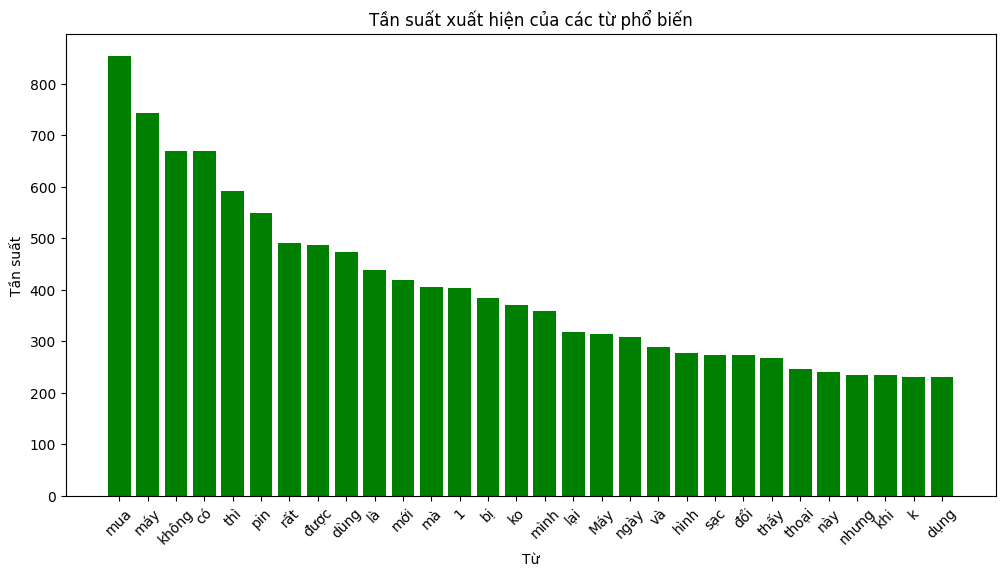

In [19]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

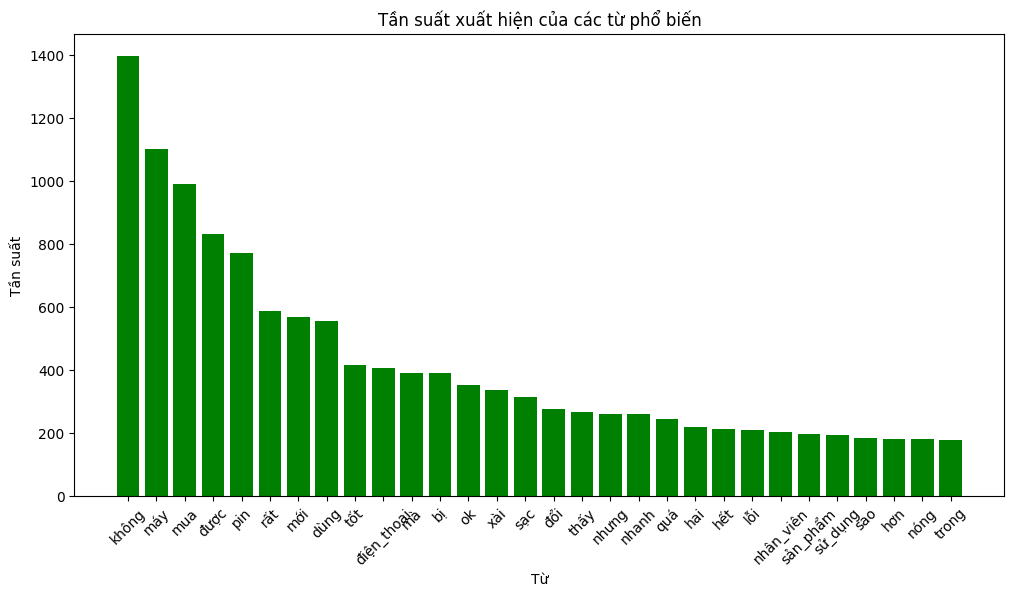

In [20]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment_clean_stage2"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

### Data before


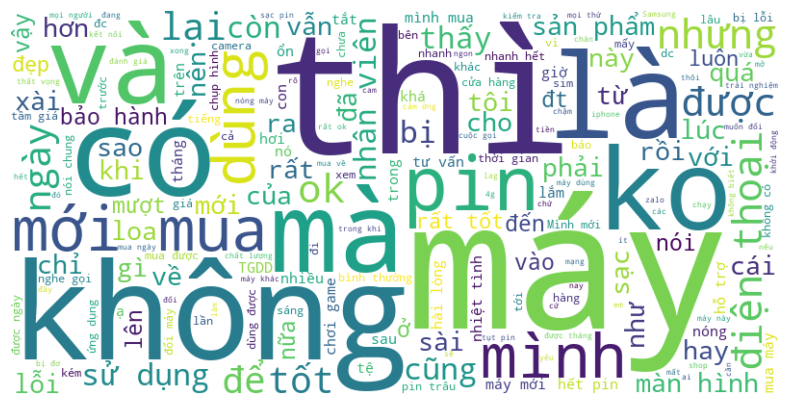

In [21]:
all_comments = " ".join(df["comment"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Data after


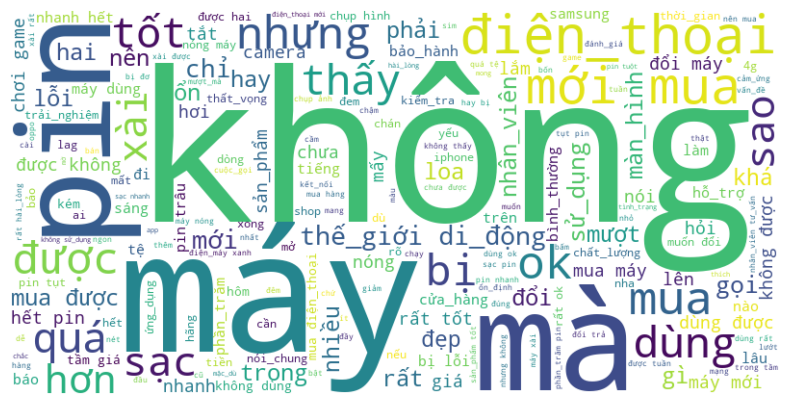

In [22]:
all_comments = " ".join(df["comment_clean_stage2"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Check lại kết quả sau khi tokenize

- Underthesea
  ![image.png](../assets/illustration/incorrect-tokenize.png)

- Cốc cốc tokenizer

![image.png](../assets/illustration/coccoc-tokenizer.png)


In [23]:
# Tìm các phần tử chứachứa từ 'pin' bên trong các bình luận ở mảng all_comments
pin_comments = set([comment for comment in all_comments.split() if "pin" in comment])
pin_comments

{'giapin',
 'lạipin',
 'mượtpin',
 'mạnhpin',
 'philippines',
 'pin',
 'pinhỏi',
 'pintầm',
 'pinđể',
 'rõpin',
 'tapin',
 'đèn_pin',
 'đơpin',
 'đếnpin'}

In [24]:
df.drop(columns=["word_count"], inplace=True)

In [ ]:
columns = [
    "product_id",
    "comment",
    "comment_clean_stage1",
    "comment_clean_stage2",
    "rating",
]

df = df[columns]
df

,product_id,comment,comment_clean_stage1,comment_clean_stage2,rating
0,honor-x8b,"Đừng mua, ko có linh kiện.","đừng mua, không có linh kiện.",đừng mua không linh_kiện,1
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,"máy sao cũng được ghét nhất cái zalo, vui nó b...",máy sao được ghét nhất vui báo hiện cuộc_gọi b...,3
2,honor-x8b,"Chiếc điện thoại mỏng nhất tôi từng dùng, cũng...","chiếc điện thoại mỏng nhất tôi từng dùng, cũng...",điện_thoại mỏng nhất dùng chip trên máy mượt h...,5
3,honor-x8b,sao hôm tôi mua lại ko dc tặng tai nghe như tr...,sao hôm tôi mua lại không được tặng tai nghe n...,sao hôm mua không được tặng tai trong giới_thi...,4
4,honor-x8b,E Mua đc 1 tuần trả lại mất bao nhiêu % ạ,em mua được một tuần trả lại mất bao nhiêu phầ...,mua được tuần trả mất bao_nhiêu phần_trăm,3
...,...,...,...,...,...
2307,xiaomi-redmi-note-13,Camera tệ thật,camera tệ thật!.,camera tệ thật,5
2308,xiaomi-redmi-note-13,"Dùng 1 thời gian có hiện tượng lang giật, ko c...","dùng một thời gian có hiện tượng lờn giật, khô...",dùng thời_gian hiện_tượng lờn giật không cảm_ứ...,3
2309,xiaomi-redmi-note-13,Tôi thấy con note 13 này chỉ mỗi pin không ổn ...,"tôi thấy con note 13 này chỉ mỗi pin không ổn,...",thấy note 13 chỉ pin không ổn nhanh hết pin kh...,3
2310,xiaomi-redmi-note-13,vừa mua xong thì giá giảm nên nhìn cái điện th...,vừa mua xong thì giá giảm nên nhìn cái điện th...,mua xong giá giảm nên điện_thoại không ưa nổi ...,2


In [27]:
df.to_csv("../../data/phone_ratings_cleaned.csv", index=False)